In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import math as m
from sklearn.metrics import mean_squared_error

Data

In [2]:
#We choose to convert the .csv file to .xls format and use pandas to parse it:
data = pd.ExcelFile("COVID19_Data_Spain.xls")
sheetX = data.parse(0) 
date = sheetX['Date']
infected = list(sheetX['Infected'])
deaths = list(sheetX['Deaths'])
recovered = list(sheetX['Recovered'])
dt = np.linspace(1,len(infected),len(infected))


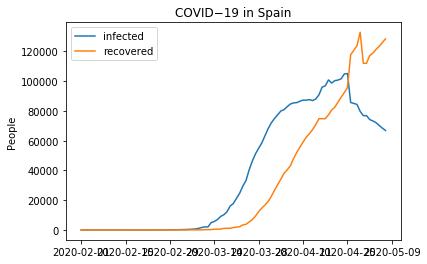

In [3]:
#Plotting real data:
plt.figure(1)
plt.plot(date,infected,label='infected')
plt.plot(date,recovered,label='recovered')
plt.title('COVID−19 in Spain')
plt.ylabel('People')
plt.legend(loc = 'best')
plt.show()

#### Scenario 1: estimating infection rate (r)

Curve fitting approach to find r and S0

In [96]:
#realmente esta celda no se utiliza...
a = 1/2.3
n = 1/5.2
I0=1
R0=0
E0=1
#N=47000000

In [78]:
#Caso SEIR model fitting
def SEIR(y0,t,r,a,n):
    S,E,I,R = y0
    dSdt=-r*S*I
    dEdt=r*S*I-n*E
    dIdt=n*E-a*I
    dRdt=a*I
    return dSdt,dEdt,dIdt,dRdt

def evolution_SEIR(t,r,S0):
    return odeint(SEIR,[S0,1,1,0],t,args =(r,1/2.3,1/5.2))[:,2]

In [6]:
params_SEIR,params_covariance_SEIR = curve_fit(evolution_SEIR,dt,infected,[1e-7,1e6]) 
r_value_SEIR = params_SEIR[0]
S0_value_SEIR = params_SEIR[1]
print('The value for r is equal to (SEIR):',r_value_SEIR)
print('The value for the initial susceptible population is (SEIR):',S0_value_SEIR)

The value for r is equal to (SEIR): 8.180995329618403e-07
The value for the initial susceptible population is (SEIR): 1480575.1895616916


#### Scenario 1: predicting when R0 becomes <1 and when the epidemic ends

In [11]:
#R0<1 and the end of the epidemic:
fit_SEIR = evolution_SEIR(dt,r_value_SEIR,S0_value_SEIR)
maximumE = max(fit_SEIR)
tmaxE = np.where(fit_SEIR==maximumE)
print('R_0<1: '+str(tmaxE[0][0])+' days.')

dt_extended = np.linspace(1,300,300)
fit_SEIR_extended = evolution_SEIR(dt_extended,r_value_SEIR,S0_value_SEIR)

fin_SEIR = 0

for index_ind in range(len(fit_SEIR_extended)):
    index_max=np.where(fit_SEIR_extended==max(fit_SEIR_extended))[0]

    if index_ind>index_max:
        if fit_SEIR_extended[index_ind] < 1:
            fin_SEIR = index_ind + 2 #0-indexing
            break 

print('No more people will get infected after '+str(fin_SEIR)+' days of epidemic.')

R_0<1: 76 days.
No more people will get infected after 175 days of epidemic.


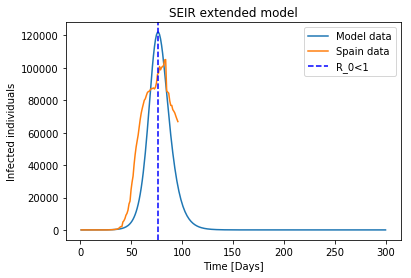

In [13]:
#Representación del resutlado:
plt.figure(1)
plt.plot(dt_extended,fit_SEIR_extended,label='Model data')
plt.plot(dt,infected,label='Spain data')


plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.axvline(76,color='blue',linestyle= 'dashed',label='R_0<1')
plt.title('SEIR extended model')
plt.legend(loc='best')
plt.show()

#### Scenario 2: estimating the quarantine factor, q

In [80]:
#We consider the starting date of the confinment the day 43
day_conf=43
dt_pre_conf=np.linspace(1,day_conf,day_conf)
infected_pre_conf=list(infected[0:day_conf])


results_pre = odeint(SEIR,[S0_value_SEIR,1,1,0],dt_pre_conf,args =(r_value_SEIR,1/2.3,1/5.2))
S, E, I, R = results_pre.T
S_new=S[-1]
E_new=E[-1]
I_new=I[-1]
R_new=R[-1]
print('The intial conditions for the confinment are S0 = ',int(S[-1]),', E0 = ',int(E[-1]),', I0 = ',int(I[-1]),
      ', R0 = ',int(R[-1]))

The intial conditions for the confinment are S0 =  1472060 , E0 =  4157 , I0 =  1294 , R0 =  3065


In [81]:
#Caso SEIR model fitting durante la cuarentena
def SEIR_conf(y0,t,r,a,n,q):
    S,E,I,R = y0
    dSdt=-r*S*I
    dEdt=r*S*I-n*E
    dIdt=n*E-a*I-q*I
    dRdt=a*I+q*I
    return dSdt,dEdt,dIdt,dRdt

def evolution_SEIR_conf(t,q):
    return odeint(SEIR_conf,[S_new,E_new,I_new,R_new],t,args =(r_value_SEIR,1/2.3,1/5.2,q))[:,2]

Encontrar rango de q con sweep

In [82]:
dt_conf = np.linspace(1,len(infected)-day_conf,len(infected)-day_conf)
infected_conf = infected[day_conf:]
q_sweep = np.linspace(0.001,10,50)


mse_c = []
for q in q_sweep:
    model_SEIR_conf = odeint(SEIR_conf,[S_new,E_new,I_new,R_new],dt[day_conf:],args =(r_value_SEIR,1/2.3,1/5.2,q))
    S, E, I, R = model_SEIR_conf.T
    #mse_r = np.sum((I-infected_conf)**2)/len(infected_conf)
    mse_r=mean_squared_error(infected_conf, I)
    mse_c.append(mse_r)
        
best_fit = min(mse_c)
index = mse_c.index(best_fit)
q_sweep_index = int(index/50)
#print(mse_c)
print('Best fit: number of q'+' '+str(q_sweep[q_sweep_index]))

Best fit: number of q 0.001


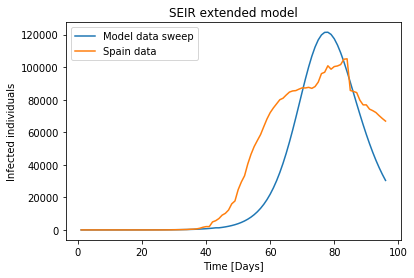

In [84]:
#Representación del resutlado:
q=q_sweep[q_sweep_index]

sweep_SEIR_conf=odeint(SEIR_conf,[S_new,E_new,I_new,R_new],dt[day_conf:],args =(r_value_SEIR,1/2.3,1/5.2,q))
S_sweep_conf, E_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SEIR_conf.T

I_conf=list(fit_SEIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data sweep')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SEIR extended model')
plt.legend(loc='best')
plt.show()


Encontrar q con curve_fit

In [85]:
params_SEIR_conf,params_covariance_SEIR_conf = curve_fit(evolution_SEIR_conf,dt[day_conf:],infected_conf,1e-2) 
q_value_SEIR_conf = params_SEIR_conf

print('The value for q is equal to:',q_value_SEIR_conf[0])

The value for q is equal to: 0.006017250218667038


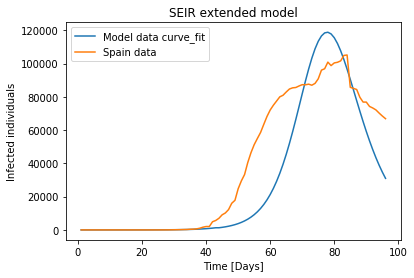

In [88]:
#Representación del resutlado:
q_value=q_value_SEIR_conf


sweep_SEIR_conf=odeint(SEIR_conf,[S_new,E_new,I_new,R_new],dt[day_conf:],args =(r_value_SEIR,1/2.3,1/5.2,q_value))
S_sweep_conf, E_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SEIR_conf.T

I_conf=list(fit_SEIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data curve_fit')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SEIR extended model')
plt.legend(loc='best')
plt.show()
#print(I_conf)

#### Scenario 2: studying the effect of the confinment level (q).

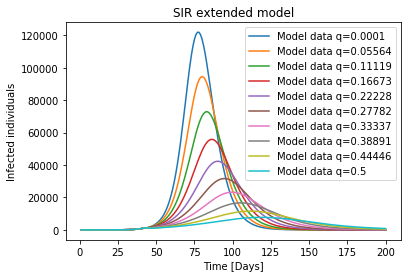

,q,I_max,When R0 becomes <1
0,0.000100,121948.0,[77]
1,0.055644,94595.0,[79]
2,0.111189,72961.0,[82]
3,0.166733,55844.0,[85]
4,0.222278,42353.0,[89]
5,0.277822,31667.0,[94]
6,0.333367,23256.0,[99]
7,0.388911,16681.0,[104]
8,0.444456,11599.0,[111]
9,0.500000,7746.0,[118]


In [93]:
#we set the date of confinment to 43
d=43
#we sweep the value of q
q_sweep=np.linspace(1e-4,5e-1,10)
#time before
dt_pre_conf=np.linspace(1,d,d)
#total time
dt_extended=np.linspace(1,200,200)


#before
results_pre = odeint(SEIR,[S0_value_SEIR,1,1,0],dt_pre_conf,args =(r_value_SEIR,1/2.3,1/5.2))
S, E, I, R = results_pre.T
S_new=S[-1]
E_new=E[-1]
I_new=I[-1]
R_new=R[-1]

#after
I_max=[]
day_max=[]
for q in q_sweep:
    SEIR_results_conf=odeint(SEIR_conf,[S_new,E_new,I_new,R_new],dt_extended[d:],args =(r_value_SEIR,1/2.3,1/5.2,q))
    S_conf, E_conf, I_conf, R_conf = SEIR_results_conf.T
    #I_conf_total=list(fit_SIR_extended[0:43])
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data q={}'.format(round(q,5)))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
data = {'q': list(q_sweep),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

#### Scenario 2: studying the effect of the date of the confinment for a level of confinment q. 

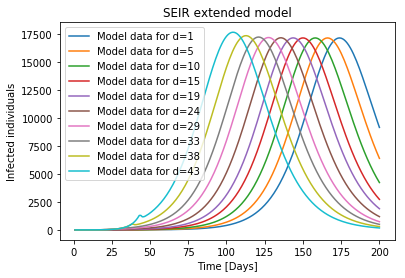

,Date,I_max,When R0 becomes <1
0,1,17119.0,[173]
1,5,17119.0,[165]
2,10,17120.0,[157]
3,15,17122.0,[149]
4,19,17122.0,[143]
5,24,17131.0,[135]
6,29,17153.0,[126]
7,33,17200.0,[120]
8,38,17321.0,[112]
9,43,17627.0,[103]


In [94]:
#we set the level of confinment to 
q=0.38
#we sweep the value of the day
d_list=np.linspace(1,43,10)
d_list=[int(d) for d in d_list]
#total time
dt_extended=np.linspace(1,200,200)

I_max=[]
day_max=[]

for d in d_list:
    #time before
    dt_pre_conf=np.linspace(1,d,d)
    #before
    results_pre = odeint(SEIR,[S0_value_SEIR,1,1,0],dt_pre_conf,args =(r_value_SEIR,1/2.3,1/5.2))
    S, E, I, R = results_pre.T
    S_new=S[-1]
    E_new=E[-1]
    I_new=I[-1]
    R_new=R[-1]

    #after
    SEIR_results_conf=odeint(SEIR_conf,[S_new,E_new,I_new,R_new],dt_extended[d:],args =(r_value_SEIR,1/2.3,1/5.2,q))
    S_conf, E_conf, I_conf, R_conf = SEIR_results_conf.T
    I_conf_total=list(I)
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt_extended,I_conf_total,label='Model data for d={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SEIR extended model')
plt.legend(loc='best')
plt.show()
data = {'Date': list(d_list),'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df    

#### Scenario 2: studying the effect of the starting date of confinment

In [95]:
#podriamos hacer los dos primeros casos como en el SIR... 